<a href="https://colab.research.google.com/github/tedteske/CRE_Monte_Carlo/blob/master/CRE_Monte_Carlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import libraries and class definition


In [0]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, truncnorm, skew, gmean
import statsmodels.api as sm # for calculating elasticities

pd.options.mode.chained_assignment = None #solve why this is necessary
#pd.set_option('max_columns', None)
pd.reset_option('max_columns') # to reset to default setting

class apartment_complex:

    def __init__(self, project_params, common_params, description=None):

        self.description = description
        self.project_params = project_params 
        # because used in print_simulation()
        
        self.v = common_params.copy()
        self.v.update(project_params) 
        # project_params override common_params where equal
        
        for k in sorted(self.v.keys()): 
            self.v[k] = self.parse_input_params(self.v[k])
            
        self.v=pd.DataFrame.from_dict(self.v,orient='columns')
        self.iter_params()
        
    def parse_input_params(self, var_params):
        '''     
        Converts model parameter item to a list of length 5 and fill blanks. 

        Parameters
        ----------
        var_params (list) : mu, sigma, lower bound, upper bound; 
            not always complete

        Returns
        -------
        var_params (list) : mu, sigma, lower bound, upper bound, 0; 
            Last list item is a placeholder for a single sample draw.
        '''

        if type(var_params) in (int, float): 
            var_params = [var_params]
        
        var_params = var_params + [0, None, None, None, None][len(var_params):] 
        var_params[2] = var_params[2] if var_params[2] != None else -np.inf
        var_params[3] = var_params[3] if var_params[3] != None else np.inf
        var_params[4] = var_params[4] if var_params[4] != None else 0

        return var_params    
    
    def sample_draw(self, var_params):
        '''
        Draws normal variates subject to lower and upper bounds. [1]

        Parameters
        ----------
        var_params (list) : mu, sigma, lower bound, upper bound

        Returns
        -------
        draw (float) : random variate from normal or truncnorm distribution
        
        Notes
        -----
        [1] see for a description of the method
            http://web.ist.utl.pt/~ist11038/compute/qc/,truncG#/lecture4k.pdf
        '''
        
        mu, sigma, lower, upper = var_params[:4]
        
        if sigma in (None, 0) or np.isnan(sigma):
            draw = mu
        else:      
            if np.isinf(lower) and np.isinf(upper): 
                # If no upper or lower bounds, draw from normal distribution.  
                draw = norm.rvs(loc=mu,scale=sigma) 
            else:  
                # Else draw from truncnorm distribution.
                lower_std, upper_std = (lower-mu)/sigma, (upper-mu)/sigma
                
                lower_pdf = norm.pdf(lower_std, loc=0, scale=1)
                upper_pdf = norm.pdf(upper_std, loc=0, scale=1)
                
                lower_cdf = norm.cdf(lower_std, loc=0, scale=1)
                upper_cdf = norm.cdf(upper_std, loc=0, scale=1)

                if np.isfinite(lower) and np.isfinite(upper): 
                    # If both lower and upper finite
                    a = upper_std * upper_pdf - lower_std * lower_pdf
                    b = upper_cdf - lower_cdf
                    c = ((upper_pdf - lower_pdf) / (upper_cdf - lower_cdf))**2               
                elif np.isfinite(lower):
                    # If lower but not upper is finite
                    a = lower_std * lower_pdf
                    b = 1 - lower_cdf
                    c = (lower_pdf / (1 - lower_cdf))**2
                else:
                    # If upper but not lower is finite
                    a = upper_std * upper_pdf
                    b = upper_cdf
                    c = (upper_pdf / upper_cdf)**2
                    
                sigma2 = np.sqrt(sigma**2/(1 - a/b - c))
                
                pdf_diff = upper_pdf - lower_pdf
                cdf_diff = upper_cdf - lower_cdf
                mu2 = mu + (sigma2 * pdf_diff / cdf_diff)
                
                draw = truncnorm.rvs((lower - mu2)/sigma2,
                                     (upper - mu2)/sigma2,
                                     loc=mu2, scale=sigma2)
                
            # to give draw same number of decimal places as mu
            #draw = round(draw, len(str(mu).split('.')[1])) 

        return draw
    
    def draw_params(self, s):
        '''
        Applies sample draw to full set of variables and append draw set to 
        dataframe

        Parameters
        ----------
        s (int) : simulation index
        '''
       
        self.v.loc[s] = self.v.loc[:4].apply(self.sample_draw, 
                                             axis=0, raw=False)
                 
    def iter_params(self, n=10): 
        '''
        Runs draw_params, simulate n times, appends simulations to multiindex 
        dataframe.

        Parameters
        ----------
        s (int) : simulation index
        n (int) : number of iterations (default 10)    
        ''' 

        index = range(5, n + 5)
        columns = self.v.columns
        df = pd.DataFrame(index=index, columns=columns)
        df = df.fillna(0) # with 0s rather than NaNs
      
        self.v = pd.concat([self.v[:5], df])
        
        for col in columns: 
            func = lambda x: self.sample_draw(self.v[col])
            self.v[col][5:] = self.v[col][5:].apply(func)
    
        p = pd.concat([self.simulate(0)], keys=[0])
        for s in index:
            p2 = pd.concat([self.simulate(s)], keys=[s])
            p = pd.concat([p, p2])    
              
        self.p = p
     
    def simulate(self,s=0):
        '''
        Simulates rental rates, occupancy, and cash flows.

        Parameters
        ----------
        s (int) : simulation index
            None if using last param set
            0 if default params
            4 if single new draw
            >4 if draw result of n iterations

        Returns
        -------
        DataFrame
        '''
        
        if s == 4: self.draw_params(s)
                
        #--- setup dataframe ---#
        index = range(0, int(self.v["years"][s]) + 1)
        columns = ['OCC', 'RATE', 'PURCH_SALE', 'CAPEX_MAINT', 'CAPEX_REHAB', 
                   'LOAN', 'PMT',
                   'REV_BASE', 'REV_PREMS', 'OE', 'NOI',
                   'FCFE', 'DSCR', 'NOIM', 'COC', 'IRR', 'NPV']
        df = pd.DataFrame(index=index, columns=columns)
        df = df.fillna(0) # with 0s rather than NaNs
        
        #--- fill with estimated values ---#
        g_years = df.index.to_numpy() - 1
        growth_oe_factor = (1 + self.v["growth_oe"][s])**g_years
        growth_revs_factor = (1 + self.v["growth_revs"][s])**g_years
        
        df['PURCH_SALE'][0] = -self.v["purch_price"][s]
        
        df['CAPEX_MAINT'][0] = -self.v["deferred_maint"][s]
        df['CAPEX_MAINT'][1:] = (self.v["rental_units"][s] 
                                 * -self.v["maint_reserve_per_unit"][s])
        df['CAPEX_MAINT'][1:] = (df['CAPEX_MAINT'] * growth_oe_factor)[1:] 
            
        stab_year = int(self.v["transition_years"][s] + 1)
        df['OCC'] = (self.v["occ_now"][s] 
                     + (self.v["occ_stab"][s] - self.v["occ_now"][s]) 
                     * (2 * df.index - 1)/(2 * self.v["transition_years"][s]))
        df['OCC'][0] = self.v["occ_now"][s]
        df['OCC'][stab_year:] = self.v["occ_stab"][s]
        
        df['RATE'] = ((self.v["rent_rate_stab"][s] - self.v["rent_rate_now"][s]) 
                      * (2 * df.index - 1) 
                      / (2 * self.v["transition_years"][s]) 
                      + self.v["rent_rate_now"][s])
        df['RATE'][0] = self.v["rent_rate_now"][s]
        df['RATE'][stab_year:] = self.v["rent_rate_stab"][s]
        
        df['REV_BASE'] = (df['RATE'] * 12 
                          * growth_revs_factor 
                          * (1 + self.v["other_income"][s]) 
                          * (1 - self.v["credit_loss"][s])
                          * self.v["rental_units"][s] 
                          * df['OCC'])
        
        rehab_costs, rehab_prems = self.rehab_effects(s)
        df['REV_PREMS'][1:] = rehab_prems
        df['CAPEX_REHAB'][1:] = -rehab_costs
        
        df['OE'] = (self.v["rental_units"][s] * (-self.v["oe_cash_per_unit"][s]) 
                          * growth_oe_factor 
                          + ((df['REV_BASE'] + df['REV_PREMS']) 
                             * -self.v["mgmt_fee"][s]))
        
        df['REV_BASE'][0], df['REV_PREMS'][0], df['OE'][0] = 0, 0, 0
        df['NOI'] = df['REV_BASE'] + df['REV_PREMS'] + df['OE']
        
        loan, payoff, pmt, io_pmt = self.loan(s)
        df['LOAN'][0] = loan
        df['PMT'][1:] = -pmt
        df['PMT'][1:int(self.v["loan_IO_term"][s] + 1)] = -io_pmt
        df['LOAN'][self.v["years"][s]] = -payoff
        
        df['PURCH_SALE'][self.v["years"][s]] = (df['NOI'][self.v["years"][s]]
                                                / self.v["caprate_exit"][s])
        
        df['FCFE'] = (df['PURCH_SALE'] + df['CAPEX_MAINT'] + df['CAPEX_REHAB'] 
                      + df['LOAN'] + df['PMT'] + df['NOI'] )
        
        df["DSCR"] = df["NOI"][1:] / -df["PMT"][1:] 
        # Debt Service Coverage Ratio
        df["IRR"] = df["FCFE"].expanding().apply(np.irr, raw=False) 
        # cumulative levered IRR to end of year
        df["COC"] = df["FCFE"][1:]/-df["FCFE"][0] # Cash-on-cash return
        df["NPV"] = np.nan # net present value
        df["NPV"][-1:] = np.npv(self.v["discount_rate"][s], df['FCFE'])
        df["NOIM"] = df["NOI"][1:] / (df['REV_BASE'][1:] + df['REV_PREMS'][1:]) 
        #NOI margin
             
        self.simulation = df
        
        return self.simulation
    
    def IRR_attrib(self, s=0, summary=False, formatted=True):
        '''     
        Decomposes levered IRR [1] into contributions from 
            market_effects
                NOI_baseline : Year 1 NOI held constant over term
                capex_maint : deferred maintenance and maintenance-type capex
                caprate_compression : capital gains from of change in caprate 
            mgmt_effects
                NOI_improvement
                capex_rehab
                purch_sale_at_caprate_entry
            leverage

        Parameters
        ----------
        s (int) : simulation index
        summary (bool) : if True, group by market_effects, mgmt_effects, 
            and leverage
        formatted (bool or str) : 
            if True, return DataFrame.
                with money and rate columns formatted for readability
            if 'pretty', format and pretty print
            if False, return DataFrame, unformatted

        Returns
        -------
        contribs (DataFrame or string print) : levered IRR, decomposed
        
        Notes
        -----
        [1] see for a description of the method
            https://www.mckinsey.com/business-functions/
            strategy-and-corporate-finance/our-insights/
            a-better-way-to-understand-internal-rate-of-return
        '''

        df = self.p.copy()
        
        def nfv(rate, vals):
            # net future value
            count = len(vals)-2
            return np.npv(rate, vals) * (1 + rate)**count

        leverage_ = df['LOAN'].loc[s] + df['PMT'].loc[s]

        IRR_unlev = np.irr(df['FCFE'].loc[s] - leverage_)
        leverage = df['IRR'].loc[s].iloc[-1] - IRR_unlev

        NOI_baseline_ = df['NOI'].loc[s].copy()
        NOI_baseline_[1:] = NOI_baseline_[1]
        NOI_baseline = nfv(IRR_unlev, NOI_baseline_)

        capex_maint = nfv(IRR_unlev, df['CAPEX_MAINT'].loc[s])

        NOI_improvement = df['NOI'].loc[s] - NOI_baseline_
        NOI_improvement = nfv(IRR_unlev, NOI_improvement)

        capex_rehab = nfv(IRR_unlev, df['CAPEX_REHAB'].loc[s])

        purch = df['PURCH_SALE'].loc[s].iloc[0]
        sale_at_caprate_entry = (df['NOI'].loc[s].iloc[-1]
                                 / self.v['caprate_entry'].loc[s])
        purch_sale_at_caprate_entry = purch + sale_at_caprate_entry

        caprate_compression = (df['NOI'].loc[s].iloc[-1]
                               / self.v['caprate_exit'].loc[s] 
                               - sale_at_caprate_entry)

        contribs = {'NOI_baseline' : NOI_baseline,
                    'capex_maint' : capex_maint,
                    'caprate_compression' : caprate_compression,
                    'NOI_improvement' : NOI_improvement,
                    'capex_rehab' : capex_rehab,
                    'purch_sale_at_caprate_entry' : purch_sale_at_caprate_entry}
        contribs = pd.Series(contribs)
        contribs = contribs/sum(contribs) * IRR_unlev
        contribs = contribs.append(pd.Series({'leverage':leverage}))

        if summary:  
            contribs = {'market_effects' : contribs[:3].sum(),
                        'mgmt_effects' : contribs[3:6].sum(),
                        'leverage' : leverage}
            contribs = pd.Series(contribs)
            
        if formatted:
                return contribs.map('{:.1%}'.format)
        else:
            return contribs

    def appraisal(self, s=0):
        '''
        Estimates an initial appraisal value and appraiser's assumed NOI.
        
        Parameters
        ----------
        s (int) : simulation index

        Returns
        -------
        appraisal_NOI (float)
        appraisal (float)
        ''' 

        if self.v["rent_rate_now"][s] in (None, 0): 
            rent_rate_appr = self.v["rent_rate_stab"][s]
        else: 
            rent_rate_appr = self.v["rent_rate_now"][s]
        
        revs_per_unit = (rent_rate_appr * 12 
                         * (1 + self.v["other_income"][s]) 
                         * (1 - self.v["credit_loss"][s]) 
                         * self.v["rental_units"][s] 
                         * self.v["occ_stab"][s]) 
        appraisal_NOI = (self.v["rental_units"][s] 
                         * (revs_per_unit - self.v["oe_appr_per_unit"][s]))
        appraisal = appraisal_NOI / self.v["caprate_entry"][s]
        
        return appraisal_NOI, appraisal 
        
    def loan(self, s=0):
        '''
        Calculates loan amount (PV), loan payment (PMT), payoff (FV), 
        and io_pmt; subject to LTV and DSCR constraints.
               
        Parameters
        ----------
        s (int) : simulation index

        Returns
        -------
        loan (float) : loan principle amount
        payoff (float) : loan payoff or balloon payment at end of horizon
        PMT (float) : annual loan payment
        io_pmt (float) : interest-only payment during IO term
        ''' 
               
        appraisal_NOI, appraisal = self.appraisal()
        rate = self.v["loan_rate"][s]
        amort = self.v["loan_amort"][s]
        LTV = self.v["loan_constraint_LTV"][s]
        DSCR = self.v["loan_constraint_DSCR"][s]
        years = self.v["years"][s]
        loan_IO_term = self.v["loan_IO_term"][s]
        costs = self.v["loan_costs"][s]
        
        PVAfactor = ((1 - 1  / (1 + rate)**amort) / rate)
        FV_factor = (1 + rate)**(years - loan_IO_term)

        if self.v["loan_amount"][s] == None:
            PV = appraisal * LTV / (1 + costs)
            PMT = -min(PV / PVAfactor, appraisal_NOI / DSCR)
            PV = PMT * PVAfactor # in case PV limited by DSCR
        else:
            PV = self.v["loan_amount"][s]
            PMT = PV / PVAfactor
        
        payoff = PV * FV_factor - PMT * ((FV_factor - 1) / rate)
        loan = PV * (1 - costs)
        io_pmt = PV * rate 
        
        return loan, payoff, PMT, io_pmt 
    
    def rehab_effects(self, s=0):
        '''
        Spreads rent-enhancing rehab costs and benefits over horizon.
               
        Parameters
        ----------
        s (int) : simulation index

        Returns
        -------
        rehab_costs (array)
        rehab_prems (array)
        '''

        turnover = self.v["turnover"][s] 
        rental_units = self.v["rental_units"][s]
        years = self.v["years"][s]
        rehab_opps = np.ceil(turnover**np.arange(0, years) * rental_units)

        cost_per_rehab = self.v["rehab_cost"][s]
        cost_g = self.v["growth_oe"][s]
        cost_g_factors = (1 + cost_g)**np.arange(0, years) 
        costs = cost_g_factors * cost_per_rehab
        rehab_costs = costs * rehab_opps * turnover

        rehab_prem = self.v["rehab_prem"][s]
        rent_g = self.v["growth_revs"][s]
        occ = self.v["occ_stab"][s] 
        rent_g_factors = (1 + rent_g)**np.arange(0, years)
        rehab_benefits_unit = rent_g_factors * rehab_prem * 12 * occ
        rehab_prems = (rental_units - rehab_opps) * rehab_benefits_unit 
        
        return rehab_costs, rehab_prems
   
    def print_simulation(self, s=None, transpose=True, formatted=True):
        '''
        Pretty prints or returns DataFrame of a single simulation. 

        Parameters
        ----------
        s (int) : simulation index
                None if using last param set
                0 if default params
                4 if single new draw
                >4 if draw result of n iterations
        transpose (bool) : if True, move columns to rows
        formatted (bool or str) : 
            if True, return DataFrame.
                with money and rate columns formatted for readability
            if 'pretty', format and pretty print
            if False, return DataFrame, unformatted

        Returns
        -------
        DataFrame if formatted=='pretty'
        '''
        
        if s == None:
            try: df = self.simulation.copy()
            except: df = self.simulate(0).copy()
        else: 
            df = self.simulate(s).copy()
        
        if formatted is not False:
            df = self.format_columns(df)

        if formatted == 'pretty':
            df[" "] = ' '  #used as a spacer
            df = df[['OCC', 'RATE', 
                     " ", 'PURCH_SALE', 'CAPEX_MAINT', 'CAPEX_REHAB', 
                     " ", 'LOAN', 'PMT',
                     " ", 'REV_BASE', 'REV_PREMS', 'OE', 'NOI',  'FCFE', 
                     " ", 'DSCR', 'NOIM', 'COC', 'IRR', 'NPV']]
            
            df = df.T # ignoring transpose flag, transpose if pretty print
            if self.description == None:
                title = "SIMULATION "+ str(s)
            else:    
                title = str(self.description).upper() + " SIMULATION " + str(s)
            print(title)
            print("=" * len(title))
            print(df)
        
        else: 
            if transpose:
                df = df.T
            return df

    def top(self, col, n=3, year=None, bottom=False, formatted=True):
        '''     
        Pretty prints or returns DataFrame of top (or bottom) n simulations 
        sorted by column col.

        Parameters
        ----------
        col (str or list of str) : param or simulation column
        n (int) : number of simulations printed (default 3)
        year (int) : year in horizon over which to calculate summary stats 
            of a simulation result. Ignored if summarizing a param.
        bottom (bool) : if True, take bottom, rather than top, n simulations
        formatted (bool or str) : 
            if True, return DataFrame.
                with money and rate columns formatted for readability
            if 'pretty', format and pretty print
            if False, return DataFrame, unformatted

        Returns
        -------
        DataFrame if formatted=='pretty'
        '''
    
        df = self.p.copy()
        
        try:
            var = self.v[col][5:]
        except:
            if year == None: 
                year = self.v["years"][0]
            var = df.xs(year, level=1).iloc[5:][col]  
        
        if bottom: 
            title = "BOTTOM "
            sims = var.nsmallest(n).index
        else: 
            title = "TOP "
            sims = var.nlargest(n).index
        
        if formatted is not False:
            df = self.format_columns(df)
        
        if formatted == 'pretty':
            print(title + str(n) + " " + col + " SCENARIOS")
            for i in sims:
                print("\n")
                self.print_simulation(i, True, 'pretty')
        else:
            return df.loc[sims].stack().unstack(level=1)
    
    def format_columns(self, df):
        '''
        Styles money and rate columns for readability and removes NaNs.
        '''

        # format money columns
        for column in ['PURCH_SALE', 'CAPEX_MAINT', 'CAPEX_REHAB', 
                       'LOAN', 'PMT', 
                       'REV_BASE', 'REV_PREMS', 'OE', 'NOI', 
                       'FCFE', 'NPV']:
            df[column] = df[column].map('{:,.0f}'.format)
        df['RATE'] = df['RATE'].map('{:,.2f}'.format)

            
        # format rate columns
        for column in ['OCC', 'IRR', 'COC', 'NOIM']:
            df[column] = df[column].map('{:,.1%}'.format)
        df["DSCR"] = df['DSCR'].map('{:,.2f}'.format) 

        for column in ['DSCR', 'IRR', 'COC', 'NPV', 'NOIM']:
            df[column].replace(['None', 'NaN', np.nan,'nan','nan%'], "", 
                                inplace=True)
            
        return df
    
    def print_params(self, s=0, print_common_params = False):   
        '''
        Pretty prints set of input params and values.  

        Parameters
        ----------
        s (int) : simulation index
                None if using last param set
                0 if default params
                4 if single new draw
                >4 if draw result of n iterations
        print_common_params (bool) : if True, include common params.
        '''
        
        df = self.v[:5]
        
        if s == 4: 
            self.draw_params(s)
        elif s > 4:
            df = pd.concat([df, self.v[s:s + 1]])
        
        assumption_set = "(estimate, stdev, min, max, draw)"
        
        if print_common_params:
            keys = sorted(self.v.keys())
            title = "ALL MODEL ASSUMPTIONS " + assumption_set
        else:    
            keys = sorted(self.project_params.keys())
            title = "PROJECT-SPECIFIC MODEL ASSUMPTIONS " + assumption_set
            
        print(title)
        print("=" * len(title)) 
        for k in keys: 
            print(k,":", df[k].tolist())
    
    def describe(self, col, year=None, scale=1):
        '''
        Prints a table of summary statistics on column(s) col.

        Parameters
        ----------
        col (str or list of str) : param or simulation column
        year (int) :  year in horizon over which to calculate summary stats 
            of a simulation result; ignored if summarizing a param
        scale (float) : scales the summary statistics
        '''

        if type(col) == str: col = [col]
        if not hasattr(scale, "__iter__"): 
            scale = [scale] * len(col) #if scale not an iterable
        df = pd.DataFrame()
        
        for i, c in enumerate(col):
            try:
                df = df.append(self.v[c][5:] * scale[i]) 
            except:
                if year == None: year = self.v["years"][0]
                df = df.append(self.p.xs(year, level=1).iloc[5:][c] * scale[i]) 
              
        described = df.T.describe([0.05,0.25,0.5,0.75,0.95])
        print(described.applymap("{0:,.2f}".format))
             
    def elasticities(self, col="NPV"):
        '''
        Print estimated param elasticities of col (e.g. occ_stab elasticity 
        of NPV) and associated p-values. Elasticities are estimated only for
        stochastic params.
        
        Parameters
        ----------
        col (str) : simulation column
        '''  

        year = self.v["years"][0]

        df1 = pd.DataFrame(self.p.xs(year, level=1).iloc[5:][col])
        
        s = ~np.isnan(self.v[1:2]).T[1]
        df2 = self.v[5:][[column for column in s[s==True].index]]
        df3 = df1.join(df2)
        
        df3 = df3[(df3 > 0).all(1)] 
        # removes any row with a negative number in any column
        
        OLS_dep_var = np.log(df3[col])  #r esponse
        OLS_ind_var = np.log(df3.drop([col], axis=1)) # predictor

        elasticity_estimate = sm.OLS(OLS_dep_var, 
                                     OLS_ind_var, missing='drop').fit()

        title = "SENSITIVITY ANALYSIS: ELASTICITY OF " 
        title += str(col) + " WITH RESPECT TO UNCERTAIN ASSUMPTIONS"
        print(title)
        print("=" * len(title))
        print (pd.DataFrame({'elasticity': elasticity_estimate.params.round(2),
                             'p-value': elasticity_estimate.pvalues.round(2)}))
    
    def plot_col(self, col, year=None, xlabel=None, 
                 scale=1, bw=0.05, kde=True):
        '''
        Plots a distribution of columns col as a histogram or kernel density 
        estimate.

        Parameters
        ----------
        col (str) : simulation column
        year (int) :  year in horizon over which to plot simulation results; 
            ignored if summarizing a param
        scale (float) : scales the variable
        xlabel (str) : label for the x-axis
        bw (float) : bandwidth
        kde (bool) : If True, display as kernel denisity estimate.
            If False, display as histogram.
                
        Example Usage
        ------------- 
        plot_col("NPV",scale=1/1e6, xlabel="NPV ($M)")
        plot_col("IRR",scale=100, xlabel="IRR (%)")
        plot_col("occ_stab",scale=100, xlabel="occ_stab (%)")
        '''
      
        try:
            var = self.v[col][5:]
        except:
            if year == None: year = self.v["years"][0]
            var = self.p.xs(year, level=1).iloc[5:][col]

        var = var.dropna()
        var = var * scale

        avg, stdev = np.mean(var), np.std(var)
        min_, max_ = np.min(var), np.max(var)
        conf_int_low = max(min_, avg - stdev * 1.96)
        conf_int_high = min(max_, avg + stdev * 1.96)       
        
        plt.figure(figsize=(10, 10/1.6)) 
        ax = sns.distplot(var, kde=kde, hist=not kde, label=col,
                        norm_hist=True, kde_kws={"bw":bw, 'shade':True})
        ax.set(xlabel=xlabel, 
                ylabel='relative frequency')

        if kde:
            c = ax.get_lines()[-1].get_c()    
            plt.axvline(avg, color=c, linestyle='dashed', label=r'$\bar{x}$')
            plt.axvline(conf_int_low, color=c, linestyle='dotted', 
                        label=r'$\bar{x} \pm 2s$')
            plt.axvline(conf_int_high, color=c, linestyle='dotted')      

        leg = plt.legend(fontsize='large')
        plt.show()

### Example usage, Quail Apartments

In [0]:
#--- parameters (estimate, stdev, lower bound, upper bound; "None" for no stdev, lower or upper)---#

#--- project-specific params: take precedence over common params where keys equal ---#

quail_params = {  "rental_units" : 200, 
                  "unit_sqft" : 750, 
                  "transition_years" : 0,
                  "rent_rate_now" : 1000, #current rates              
                  "rent_rate_stab" : [1000, 50], 
                  "occ_now" : 0.9,
                  "occ_stab" : [0.90, 0.1, 0, 0.98], 
                  "oe_cash_per_unit" : [5400, 300],
                  "oe_appr_per_unit" : 5400,  
                  "mgmt_fee" : 0.00,             
                  "maint_reserve_per_unit" : 300,
                  "credit_loss" : 0,
                  "caprate_entry" : 0.055, 
                  "caprate_exit" : [0.060, 0.01, 0.055],
                  "loan_rate" : 0.0350,
                  "loan_constraint_LTV" : 0.75,
                  "loan_constraint_DSCR" : 1.25,
                  "loan_amort" : 30,
                  "loan_amount" : [14727273], #[None] if no loan commitment
                  "loan_IO_term" : 0, 
                  "loan_costs" : 0, # as a fraction of loan amount
                  "other_income" : [0], 
                  "growth_revs" : [0.030, 0.015],  
                  "growth_oe" : [0.025, 0.015], 
                  "purch_price": 19636364, 
                  "deferred_maint" : 2000000,
                  "turnover" : 0.5,
                  "rehab_prem" : [150, 50],
                  "rehab_cost" : [15000, 75]
                  }

#--- common params: project-specific params take precedence where keys equal ---#
common_params =  {"discount_rate" : 0.10, #caprate + average growth in NOI
                  "years" : 5} 
                  
#Initialize quail, an apartment complex of class apartment, and run 100 simulations

quail = apartment_complex(quail_params, common_params, 
                          description = "Quail Apartments")
quail.iter_params(100)

In [74]:
mu = '0.90'
draw = 0.98
round(draw, len(str(mu).split('.')[1]))
str(mu)

'0.90'

In [43]:
quail.IRR_attrib(summary=True, formatted=True)

market_effects    0.4%
mgmt_effects      6.4%
leverage          4.8%
dtype: object

In [44]:
quail.print_simulation(0, transpose=False, formatted='pretty')

QUAIL APARTMENTS SIMULATION 0
                       0           1  ...           4            5
OCC                90.0%       90.0%  ...       90.0%        90.0%
RATE            1,000.00    1,000.00  ...    1,000.00     1,000.00
                                      ...                         
PURCH_SALE   -19,636,364           0  ...           0   26,332,379
CAPEX_MAINT   -2,000,000     -60,000  ...     -64,613      -66,229
CAPEX_REHAB            0  -1,500,000  ...    -201,917     -107,622
                                      ...                         
LOAN          14,727,273           0  ...           0  -13,197,431
PMT                    0    -800,741  ...    -800,741     -800,741
                                      ...                         
REV_BASE               0   2,160,000  ...   2,360,290    2,431,099
REV_PREMS              0           0  ...     309,788      340,962
OE                     0  -1,080,000  ...  -1,163,042   -1,192,118
NOI                    0   1,080

In [18]:
#best 3 simulations
quail.top("IRR", formatted='pretty')

TOP 3 IRR SCENARIOS


QUAIL APARTMENTS SIMULATION 50
                       0           1  ...           4            5
OCC                90.0%      100.0%  ...      100.0%       100.0%
RATE            1,000.00    1,056.70  ...    1,056.70     1,056.70
                                      ...                         
PURCH_SALE   -19,636,364           0  ...           0   38,267,671
CAPEX_MAINT   -2,000,000     -60,000  ...     -61,818      -62,436
CAPEX_REHAB            0  -1,510,470  ...    -194,530     -102,167
                                      ...                         
LOAN          14,727,273           0  ...           0  -13,197,431
PMT                    0    -800,741  ...    -800,741     -800,741
                                      ...                         
REV_BASE               0   2,536,080  ...   2,852,745    2,966,855
REV_PREMS              0           0  ...     453,073      503,506
OE                     0  -1,128,480  ...  -1,162,674   -1,174,301
NOI      

In [19]:
# worst 3 simulations
quail.top("IRR", bottom=True, formatted=True)

0           1  ...           4            5
40 OCC                90.0%       80.0%  ...       80.0%        80.0%
   RATE            1,000.00      959.50  ...      959.50       959.50
   PURCH_SALE   -19,636,364           0  ...           0   13,607,451
   CAPEX_MAINT   -2,000,000     -60,000  ...     -69,061      -72,376
   CAPEX_REHAB            0  -1,513,030  ...    -217,691     -118,633
   LOAN          14,727,273           0  ...           0  -13,197,431
   PMT                    0    -800,741  ...    -800,741     -800,741
   REV_BASE               0   1,842,240  ...   1,842,240    1,842,240
   REV_PREMS              0           0  ...     225,792      241,275
   OE                     0  -1,050,400  ...  -1,209,034   -1,267,068
   NOI                    0     791,840  ...     858,998      816,447
   FCFE          -6,909,091  -1,581,931  ...    -228,496      234,716
   DSCR                            0.99  ...        1.07         1.02
   NOIM                           43.0%  ...       41.5%        39.2%
   COC                           -22.9%  ...       -3.3%         3.4%
   IRR                                   ...                   -64.3%
   NPV                                   ...               -9,307,626
73 OCC                90.0%       80.0%  ...       80.0%        80.0%
   RATE            1,000.00      959.80  ...      959.80       959.80
   PURCH_SALE   -19,636,364           0  ...           0   13,379,313
   CAPEX_MAINT   -2,000,000     -60,000  ...     -63,485      -64,692
   CAPEX_REHAB            0  -1,507,960  ...    -199,445     -105,682
   LOAN          14,727,273           0  ...           0  -13,197,431
   PMT                    0    -800,741  ...    -800,741     -800,741
   REV_BASE               0   1,842,816  ...   1,842,816    1,842,816
   REV_PREMS              0           0  ...     151,200      161,568
   OE                     0  -1,114,480  ...  -1,179,220   -1,201,625
   NOI                    0     728,336  ...     814,796      802,759
   FCFE          -6,909,091  -1,640,365  ...    -248,875       13,526
   DSCR                            0.91  ...        1.02         1.00
   NOIM                           39.5%  ...       40.9%        40.1%
   COC                           -23.7%  ...       -3.6%         0.2%
   IRR                                   ...                   -95.0%
   NPV                                   ...               -9,583,407
93 OCC                90.0%       80.0%  ...       80.0%        80.0%
   RATE            1,000.00      953.90  ...      953.90       953.90
   PURCH_SALE   -19,636,364           0  ...           0   14,426,332
   CAPEX_MAINT   -2,000,000     -60,000  ...     -68,667      -71,825
   CAPEX_REHAB            0  -1,479,850  ...    -211,701     -115,148
   LOAN          14,727,273           0  ...           0  -13,197,431
   PMT                    0    -800,741  ...    -800,741     -800,741
   REV_BASE               0   1,831,488  ...   1,943,590    1,982,462
   REV_PREMS              0           0  ...     211,800      230,850
   OE                     0  -1,125,840  ...  -1,288,462   -1,347,732
   NOI                    0     705,648  ...     866,928      865,580
   FCFE          -6,909,091  -1,634,943  ...    -214,182    1,106,766
   DSCR                            0.88  ...        1.08         1.08
   NOIM                           38.5%  ...       40.2%        39.1%
   COC                           -23.7%  ...       -3.1%        16.0%
   IRR                                   ...                   -41.4%
   NPV                                   ...               -8,856,142

[51 rows x 6 columns]

In [45]:
quail.elasticities("IRR")

SENSITIVITY ANALYSIS: ELASTICITY OF IRR WITH RESPECT TO UNCERTAIN ASSUMPTIONS
                  elasticity  p-value
rent_rate_stab         11.28     0.00
occ_stab                9.11     0.00
oe_cash_per_unit       -5.58     0.00
caprate_exit           -5.23     0.00
growth_revs             0.74     0.00
growth_oe              -0.30     0.04
rehab_prem              0.91     0.01
rehab_cost             -5.13     0.01


In [46]:
quail.print_params(95)

PROJECT-SPECIFIC MODEL ASSUMPTIONS (estimate, stdev, min, max, draw)
caprate_entry : [0.055, nan, -inf, inf, 0.0, 0.055]
caprate_exit : [0.06, 0.01, 0.055, inf, 0.0, 0.06]
credit_loss : [0.0, nan, -inf, inf, 0.0, 0.0]
deferred_maint : [2000000.0, nan, -inf, inf, 0.0, 2000000.0]
growth_oe : [0.025, 0.015, -inf, inf, 0.0, 0.006]
growth_revs : [0.03, 0.015, -inf, inf, 0.0, 0.03]
loan_IO_term : [0.0, nan, -inf, inf, 0.0, 0.0]
loan_amort : [30.0, nan, -inf, inf, 0.0, 30.0]
loan_amount : [14727273.0, nan, -inf, inf, 0.0, 14727273.0]
loan_constraint_DSCR : [1.25, nan, -inf, inf, 0.0, 1.25]
loan_constraint_LTV : [0.75, nan, -inf, inf, 0.0, 0.75]
loan_costs : [0.0, nan, -inf, inf, 0.0, 0.0]
loan_rate : [0.035, nan, -inf, inf, 0.0, 0.035]
maint_reserve_per_unit : [300.0, nan, -inf, inf, 0.0, 300.0]
mgmt_fee : [0.0, nan, -inf, inf, 0.0, 0.0]
occ_now : [0.9, nan, -inf, inf, 0.0, 0.9]
occ_stab : [0.9, 0.1, 0.0, 0.98, 0.0, 0.9]
oe_appr_per_unit : [5400.0, nan, -inf, inf, 0.0, 5400.0]
oe_cash_per_uni

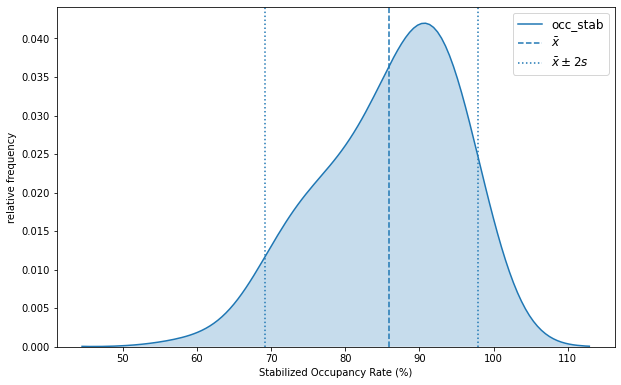

In [52]:
quail.plot_col("occ_stab", scale=100, bw=0.05*100, kde=True,
                xlabel="Stabilized Occupancy Rate (%)")

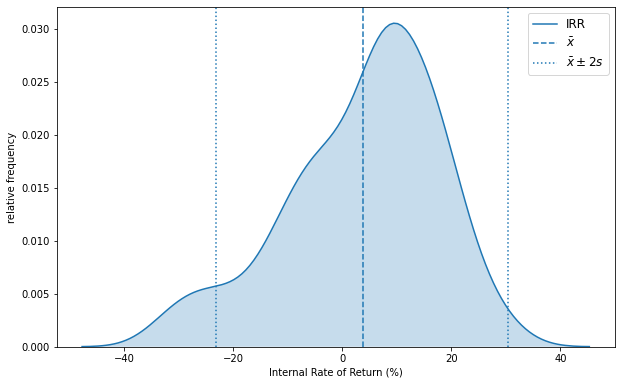

In [69]:
quail.plot_col("IRR", scale=100, bw=0.05*100, 
                xlabel="Internal Rate of Return (%)")

In [39]:
year = 5
col = "NPV"
round(skew(quail.p.xs(year, level=1).loc[5:][col]),2) 

-0.06

In [70]:
quail.describe(["IRR","rent_rate_stab", "occ_stab"], scale=(100,1,100))

          IRR rent_rate_stab occ_stab
count   93.00         100.00   100.00
mean     3.77       1,005.64    85.93
std     13.85          50.45     8.58
min    -32.73         876.44    59.50
5%     -24.09         931.54    70.57
25%     -5.23         967.37    79.88
50%      6.68       1,007.29    88.38
75%     14.07       1,039.52    92.40
95%     22.35       1,077.50    96.75
max     30.29       1,127.85    97.91
